# Conceptual

### 1. Using basic statistical properties of the variance, as well as single variable calculus, derive (5.6). In other words, prove that $\alpha$ given by (5.6) does indeed minimize $Var(\alpha X + (1 − \alpha) Y)$

Use:
$$
Var(aX + bY) = a^2 Var(X) + b^2 Var(y) + 2Cov(X, Y)
$$

Solution:
$$
f(\alpha) = Var(\alpha X + (1 − \alpha) Y) = \alpha^2 \sigma_X^2 + (1 - \alpha) \sigma_Y^2 + 2\alpha(1-\alpha) \sigma_{XY} \\
\iff \frac{\partial f}{\partial \alpha} = 0 \implies \
2\alpha \sigma_X^2 - 2 \sigma_Y^2 + 2 \alpha \sigma_Y^2 + 2 \sigma_{XY} - 4 \alpha \sigma_{XY} = 0 \\
\implies \alpha = \frac{ \sigma_Y^2 - \sigma_{XY} }{ \sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY} }
$$

### 2. We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of $n$ observations.
a) What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.
$$
(n - 1) / n = 1 - \frac{1}{n}
$$

b) What is the probability that the second bootstrap observation is not the jth observation from the original sample?
$$
(n - 1) / n = 1 - \frac{1}{n}
$$
c) Argue that the probability that the jth observation is not in the bootstrap sample is $(1 − 1/n)^n$
- jth observation cannot be the first, second, ... nth bootstrap sample: $(1 − 1/n)^n$

d) When $n = 5$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/5)^5 = 1 - 0.33 = 0.67 
$$

e) When $n = 100$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/100)^{100} = 1 - 0.366 = 0.634
$$

f) When $n = 10 000$, what is the probability that the jth observation is in the bootstrap sample?
$$
1 - (1 − 1/n)^n = 1 - (1 − 1/10000)^{10000} = 1 - 0.366 = 0.632
$$

g) Create a plot that displays, for each integer value of n from 1 to 100, 000, the probability that the jth observation is in the bootstrap sample. Comment on what you observe
- The probability that any of the observations is in the bootstrap sample for large values of $n$ is around 0.632 (or $1 - \frac{1}{e})$

In [35]:
import matplotlib.pyplot as plt
import numpy as np

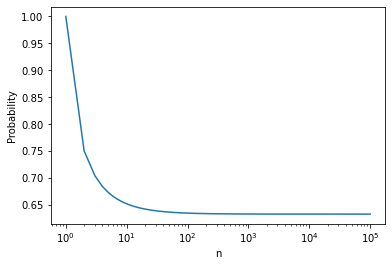

In [40]:
x = list(range(1, 100000))
y = [1 - (1 - 1/n)**n for n in x]
fig, ax = plt.subplots(1, 1)
ax.set(xscale = "log", xlabel = "n", 
       ylabel = "Probability")
ax.plot(x, y)

(h) We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.
- The simulation confirms the above considerations

In [33]:
samples, n, j = 10000, 100, 4
present_count = 0
for s in range(samples):
    bootstrap = np.random.randint(1, 100, 100)
    if j in bootstrap: present_count += 1
print(f"Proportion of bootstrap samples containing j: {present_count/samples}")

Proportion of bootstrap samples containing j: 0.6321


### 3. We now review k-fold cross-validation.
(a) Explain how k-fold cross-validation is implemented
- We split the dataset into $k$ disjoint subsets. Then, we fit our model $k$ times, each time using different combination of $k-1$ subsets (concatenated together) for training, and then, evaluating the model performance on the remaining subset not used for training. Cross-validation performance of the model is the average validation performance across the $k$ runs

(b) What are the advantages and disadvantages of k-fold crossvalidation relative to:

i. The validation set approach?
- K-fold CV estimate is less biased - the model will have been tested on all samples. Validation set performance varies depending on the data that was included in the training vs. validation set
- K-fold is computationally more expensive (we train the model $k$ times)

ii. LOOCV?
- K-fold CV estimate is more biased - LOOCV uses almost all possible training data to fit the model
- K-fold CV estimate has less variance - in LOOCV the training subsets overlap almost exactly. And the mean of many highly correlated quantities has a higher variance 
- K-fold CV estimate is computationally less expensive - LOOCV requires training the model $k$ times

### 4. Suppose that we use some statistical learning method to make a prediction for the response $Y$ for a particular value of the predictor $X$. Carefully describe how we might estimate the standard deviation of our prediction.
- We can create $n$ bootstrap samples from our original dataset $D$. Then, we fit our model on each of the bootstrap samples and calculate $Y_i = f_i(X)$ where $f_i$ is the i'th model fit on i'th bootstrap sample. We can estimate the SD of our prediction with: 
$$
\hat{\sigma} = \sqrt{ \frac{1}{B-1} \sum_{i=0}^{B} (f_i(X) - \bar{f_i(X)})^2}
$$